In [1]:
!pip install kaggle
!mkdir -p /root/.kaggle
!cp kaggle.json /root/.kaggle/


cp: cannot stat 'kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio
!kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess
!kaggle datasets download -d ejlok1/cremad
!kaggle datasets download -d ejlok1/surrey-audiovisual-expressed-emotion-savee
!kaggle datasets download -d kingabzpro/urdu-emotion-dataset


Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
License(s): CC-BY-NC-SA-4.0
 99% 427M/429M [00:20<00:00, 22.6MB/s]
100% 429M/429M [00:20<00:00, 21.9MB/s]
Dataset URL: https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
100% 428M/428M [00:19<00:00, 21.1MB/s]
100% 428M/428M [00:19<00:00, 22.5MB/s]
Dataset URL: https://www.kaggle.com/datasets/ejlok1/cremad
License(s): ODC Attribution License (ODC-By)
 99% 448M/451M [00:20<00:00, 24.0MB/s]
100% 451M/451M [00:21<00:00, 22.5MB/s]
Dataset URL: https://www.kaggle.com/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee
License(s): copyright-authors
100% 107M/107M [00:05<00:00, 24.5MB/s]
100% 107M/107M [00:05<00:00, 19.2MB/s]
Dataset URL: https://www.kaggle.com/datasets/kingabzpro/urdu-emotion-dataset
License(s): other
100% 72.0M/72.1M [00:05<00:00, 21.4MB/s]
100% 72.1M/72.1M [00:05<00:00, 14

# Mental Health Detection

The purpose of this notebook is to classify from raw sound waves to six states of mental health: happy, sad, neutral, fear, angry, and disgust.

We would do the following parts in squence:
1. Loading the datasets
2. Exploratory Data Analysis
3. Audio Preprocessing
4. Extracting features like mfccs
5. Predictive Modelling
6. Evaluation
7. Testing
8. Conclusion

We would be using the following Datasets for training:
* Crowd-sourced Emotional Multimodal Actors Dataset (Crema-D)
* Ryerson Audio-Visual Database of Emotional Speech and Song (Ravdess)
* Surrey Audio-Visual Expressed Emotion (Savee)
* Toronto Emotional Speech Set (Tessa)

# 1. Loading the Datasets

We will gather speech data from four datasets and store it in a single dataframe along with the corresponding file paths, gender labels and emotion labels.

In [3]:
import os
import pandas as pd
import numpy as np

In [4]:
!unzip ravdess-emotional-speech-audio.zip -d /content/ravdess/
!unzip toronto-emotional-speech-set-tess.zip -d /content/tess/
!unzip cremad.zip -d /content/cremad/
!unzip surrey-audiovisual-expressed-emotion-savee.zip -d /content/savee/
!unzip urdu-emotion-dataset.zip -d /content/urdu_emotion/


Streaming output truncated to the last 5000 lines.
  inflating: /content/cremad/AudioWAV/1041_TAI_SAD_XX.wav  
  inflating: /content/cremad/AudioWAV/1041_TIE_ANG_XX.wav  
  inflating: /content/cremad/AudioWAV/1041_TIE_DIS_XX.wav  
  inflating: /content/cremad/AudioWAV/1041_TIE_FEA_XX.wav  
  inflating: /content/cremad/AudioWAV/1041_TIE_HAP_XX.wav  
  inflating: /content/cremad/AudioWAV/1041_TIE_NEU_XX.wav  
  inflating: /content/cremad/AudioWAV/1041_TIE_SAD_XX.wav  
  inflating: /content/cremad/AudioWAV/1041_TSI_ANG_XX.wav  
  inflating: /content/cremad/AudioWAV/1041_TSI_DIS_XX.wav  
  inflating: /content/cremad/AudioWAV/1041_TSI_FEA_XX.wav  
  inflating: /content/cremad/AudioWAV/1041_TSI_HAP_XX.wav  
  inflating: /content/cremad/AudioWAV/1041_TSI_NEU_XX.wav  
  inflating: /content/cremad/AudioWAV/1041_TSI_SAD_XX.wav  
  inflating: /content/cremad/AudioWAV/1041_WSI_ANG_XX.wav  
  inflating: /content/cremad/AudioWAV/1041_WSI_DIS_XX.wav  
  inflating: /content/cremad/AudioWAV/1041_WSI_FE

In [5]:
# Update these paths to point to the correct directories where you unzipped the data
RAVDESS = "/content/ravdess/audio_speech_actors_01-24/"
CREMA = "/content/cremad/AudioWAV/"
TESS = "/content/tess/tess toronto emotional speech set data/"
SAVEE = "/content/savee/ALL/"


**1. Ravdess Dataframe**

There are 1440 audio files, for example, 03-01-**06**-01-02-01-12.wav.

In [6]:
# RAVDESS Dataset Processing
ravdess_dir_lis = os.listdir(RAVDESS)
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {
    '03' : 'happy',
    '01' : 'neutral',
    '04' : 'sad',
    '05' : 'angry',
    '06' : 'fear',
    '07' : 'disgust',
}

for directory in ravdess_dir_lis:
    actor_files = os.listdir(os.path.join(RAVDESS, directory))
    for audio_file in actor_files:
        part = audio_file.split('.')[0]
        key = part.split('-')[2]
        if key in emotion_dic:
            gender_code = int(part.split('-')[6])
            path_list.append(f"{RAVDESS}{directory}/{audio_file}")
            gender_list.append('female' if gender_code & 1 == 0 else 'male')
            emotion_list.append(emotion_dic[key])

ravdess_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

print(ravdess_df.head())


                                                path   sex emotion
0  /content/ravdess/audio_speech_actors_01-24/Act...  male    fear
1  /content/ravdess/audio_speech_actors_01-24/Act...  male   angry
2  /content/ravdess/audio_speech_actors_01-24/Act...  male     sad
3  /content/ravdess/audio_speech_actors_01-24/Act...  male   angry
4  /content/ravdess/audio_speech_actors_01-24/Act...  male     sad


**2. Crema-D Dataframe**

There are 7,442 audio files, for example, 1001_DFA_**ANG**_XX.wav.

In [7]:

# CREMA Dataset Processing
crema_dir_list = os.listdir(CREMA)
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {
    'HAP' : 'happy',
    'NEU' : 'neutral',
    'SAD' : 'sad',
    'ANG' : 'angry',
    'FEA' : 'fear',
    'DIS' : 'disgust',
}

female_id_list = [
    '1002', '1003', '1004', '1006', '1007', '1008', '1009', '1010', '1012', '1013', '1018',
    '1020', '1021', '1024', '1025', '1028', '1029', '1030', '1037', '1043', '1046', '1047',
    '1049', '1052', '1053', '1054', '1055', '1056', '1058', '1060', '1061', '1063', '1072',
    '1073', '1074', '1075', '1076', '1078', '1079', '1082', '1084', '1089', '1091',
]

for audio_file in crema_dir_list:
    part = audio_file.split('_')
    if len(part) > 3:
        key = part[2]
        if key in emotion_dic and part[3] == 'HI.wav':
            path_list.append(f"{CREMA}{audio_file}")
            gender_list.append('female' if part[0] in female_id_list else 'male')
            emotion_list.append(emotion_dic[key])

crema_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

print(crema_df.head())

                                           path     sex  emotion
0  /content/cremad/AudioWAV/1032_IEO_HAP_HI.wav    male    happy
1  /content/cremad/AudioWAV/1065_IEO_FEA_HI.wav    male     fear
2  /content/cremad/AudioWAV/1050_IEO_HAP_HI.wav    male    happy
3  /content/cremad/AudioWAV/1011_IEO_FEA_HI.wav    male     fear
4  /content/cremad/AudioWAV/1060_IEO_DIS_HI.wav  female  disgust


**3. Tess Dataframe**

There are 2,800 audio files, for example, OAF_base_**fear**.wav.

In [8]:
print("First few files in TESS directory:")
for directory in tess_dir_list[:3]:  # First two directories
    print(os.listdir(os.path.join(TESS, directory))[:10])  # Print first 5 files


First few files in TESS directory:


NameError: name 'tess_dir_list' is not defined

In [36]:
import os
import pandas as pd

# Define the main directory for TESS dataset
TESS = "tess"  # Update this path to the correct location

# Define the subdirectory where the audio files are located
subdirectory = "TESS Toronto emotional speech set data"  # The nested directory

# TESS Dataset Processing
tess_dir_list = os.listdir(os.path.join(TESS, subdirectory))  # Now accessing the correct subdirectory
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {
    'happy'   : 'happy',
    'neutral' : 'neutral',
    'sad'     : 'sad',
    'Sad'     : 'sad',
    'angry'   : 'angry',
    'fear'    : 'fear',
    'disgust' : 'disgust',
}

# Check the full path and filenames
print("Inspecting directories and filenames in TESS dataset:")
for directory in tess_dir_list[:2]:  # Check first two directories
    full_path = os.path.join(TESS, subdirectory, directory)
    print(f"\nFiles in {full_path}:")
    print(os.listdir(full_path))  # List files in the directory

# Loop through directories and files
for directory in tess_dir_list:
    full_directory_path = os.path.join(TESS, subdirectory, directory)
    audio_files = os.listdir(full_directory_path)
    for audio_file in audio_files:
        part = audio_file.split('.')[0]
        parts = part.split('_')
        if len(parts) > 2:  # Ensure filename is correctly split
            key = parts[2]  # Emotion is at position 2
            if key in emotion_dic:
                # Properly join the path
                path_list.append(os.path.join(TESS, subdirectory, directory, audio_file))
                gender_list.append('female')  # female only dataset
                emotion_list.append(emotion_dic[key])

# Create DataFrame
tess_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

# Display the first few rows
print("\nDataframe:")
print(tess_df.head())


Inspecting directories and filenames in TESS dataset:

Files in tess/TESS Toronto emotional speech set data/OAF_neutral:
['OAF_tell_neutral.wav', 'OAF_half_neutral.wav', 'OAF_live_neutral.wav', 'OAF_late_neutral.wav', 'OAF_match_neutral.wav', 'OAF_sell_neutral.wav', 'OAF_met_neutral.wav', 'OAF_kick_neutral.wav', 'OAF_week_neutral.wav', 'OAF_room_neutral.wav', 'OAF_boat_neutral.wav', 'OAF_juice_neutral.wav', 'OAF_vine_neutral.wav', 'OAF_beg_neutral.wav', 'OAF_numb_neutral.wav', 'OAF_shall_neutral.wav', 'OAF_puff_neutral.wav', 'OAF_shirt_neutral.wav', 'OAF_thought_neutral.wav', 'OAF_lose_neutral.wav', 'OAF_when_neutral.wav', 'OAF_jar_neutral.wav', 'OAF_sure_neutral.wav', 'OAF_check_neutral.wav', 'OAF_tape_neutral.wav', 'OAF_pad_neutral.wav', 'OAF_talk_neutral.wav', 'OAF_sour_neutral.wav', 'OAF_white_neutral.wav', 'OAF_bath_neutral.wav', 'OAF_rat_neutral.wav', 'OAF_near_neutral.wav', 'OAF_pass_neutral.wav', 'OAF_death_neutral.wav', 'OAF_yearn_neutral.wav', 'OAF_chain_neutral.wav', 'OAF_de

**4. Save Dataframe**

There are 480 audio files, for example, DC_**a**02.wav.

In [37]:
savee_dir_list = os.listdir(SAVEE)
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {
    'h'  : 'happy',
    'n'  : 'neutral',
    'sa' : 'sad',
    'a'  : 'angry',
    'f'  : 'fear',
    'd'  : 'disgust'
}

for audio_file in savee_dir_list:
    part = audio_file.split('_')[1]
    key = part[:-6]
    if key in emotion_dic:
        path_list.append(f"{SAVEE}{audio_file}")
        gender_list.append('male') # male only dataset
        emotion_list.append(emotion_dic[key])

savee_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

print(savee_df.head())


                            path   sex  emotion
0  /content/savee/ALL/JE_n30.wav  male  neutral
1  /content/savee/ALL/JE_n17.wav  male  neutral
2  /content/savee/ALL/JK_n11.wav  male  neutral
3  /content/savee/ALL/DC_a11.wav  male    angry
4  /content/savee/ALL/JE_f02.wav  male     fear


Now we add all of the above loaded Dataframes into a single dataframe

In [38]:
df = pd.concat([ravdess_df, crema_df, tess_df, savee_df], axis=0, ignore_index=True)
print(df.head())


                                                path   sex emotion
0  /content/ravdess/audio_speech_actors_01-24/Act...  male    fear
1  /content/ravdess/audio_speech_actors_01-24/Act...  male   angry
2  /content/ravdess/audio_speech_actors_01-24/Act...  male     sad
3  /content/ravdess/audio_speech_actors_01-24/Act...  male   angry
4  /content/ravdess/audio_speech_actors_01-24/Act...  male     sad


In [39]:
df = df.sample(frac=1).reset_index(drop=True)


In [40]:
df

,path,sex,emotion
0,tess/TESS Toronto emotional speech set data/OA...,female,sad
1,tess/TESS Toronto emotional speech set data/OA...,female,happy
2,tess/TESS Toronto emotional speech set data/OA...,female,disgust
3,/content/savee/ALL/JE_a01.wav,male,angry
4,tess/TESS Toronto emotional speech set data/YA...,female,neutral
...,...,...,...
4326,tess/TESS Toronto emotional speech set data/YA...,female,sad
4327,tess/TESS Toronto emotional speech set data/YA...,female,fear
4328,tess/TESS Toronto emotional speech set data/OA...,female,fear
4329,/content/cremad/AudioWAV/1009_IEO_SAD_HI.wav,female,sad


In [41]:
df['emotion'].value_counts()

,count
emotion,
sad,743
happy,743
disgust,743
angry,743
fear,743
neutral,616


# 2. Exploratory Data Analysis

We check for imbalances like male to female ratio to understand our data better.

In [42]:
import librosa
import matplotlib.pyplot as plt

plt.style.use('ggplot')

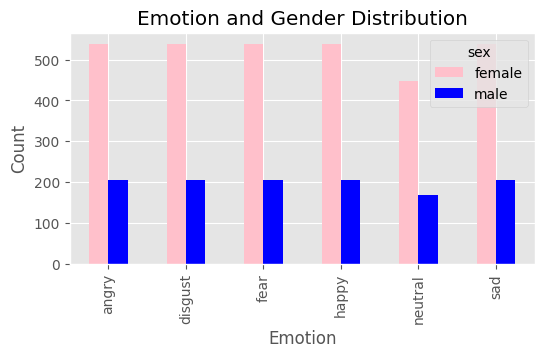

In [43]:
def plot_distribution(df):
    countTable = df.groupby(['emotion', 'sex']).count()
    pivotTable = countTable.pivot_table(index='emotion', columns='sex', values='path')

    pivotTable.plot(kind='bar', figsize=(6, 3), color=['pink', 'blue'])
    plt.title('Emotion and Gender Distribution')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.show()

plot_distribution(df)

As we can see from the above bar chart, the female voices are much more than the male voices which could create a bias. Therefore I decided to move on only with the female voices.

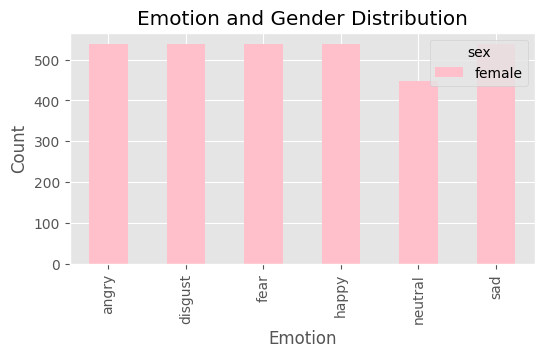

In [44]:
# I decided to go with a female specific model
df = df[df['sex'] == 'female']
plot_distribution(df)

Now the data is much balanced between different categories

In [45]:
df.head()

,path,sex,emotion
0,tess/TESS Toronto emotional speech set data/OA...,female,sad
1,tess/TESS Toronto emotional speech set data/OA...,female,happy
2,tess/TESS Toronto emotional speech set data/OA...,female,disgust
4,tess/TESS Toronto emotional speech set data/YA...,female,neutral
5,tess/TESS Toronto emotional speech set data/YA...,female,happy


Since the 'sex' column is irrelevant to us. We can remove it now.

In [46]:
df.drop('sex', axis=1, inplace=True)
df.head()

<ipython-input-46-4055417079d5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('sex', axis=1, inplace=True)


,path,emotion
0,tess/TESS Toronto emotional speech set data/OA...,sad
1,tess/TESS Toronto emotional speech set data/OA...,happy
2,tess/TESS Toronto emotional speech set data/OA...,disgust
4,tess/TESS Toronto emotional speech set data/YA...,neutral
5,tess/TESS Toronto emotional speech set data/YA...,happy


Now let's plot some waveplots to look how they differs for different categories

In [47]:
from IPython.display import Audio

def create_waveplot(y, sr, title):
    plt.figure(figsize=(8, 2))
    plt.title(title)
    librosa.display.waveshow(y, sr=sr)
    plt.show()

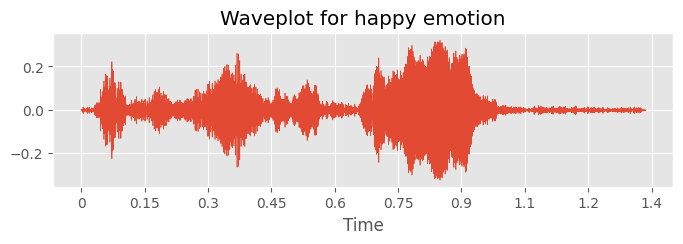

In [48]:
emotion_label = 'happy'
title = f"Waveplot for {emotion_label} emotion"
path = np.array(df.path[df.emotion == emotion_label])[2]
y, sr = librosa.load(path)

create_waveplot(y, sr, title)
Audio(path)

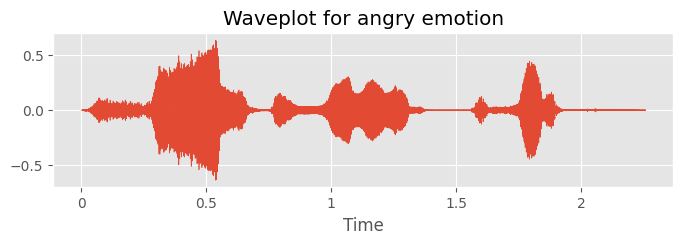

In [49]:
emotion_label = 'angry'
title = f"Waveplot for {emotion_label} emotion"
path = np.array(df.path[df.emotion == emotion_label])[2]
y, sr = librosa.load(path)

create_waveplot(y, sr, title)
Audio(path)

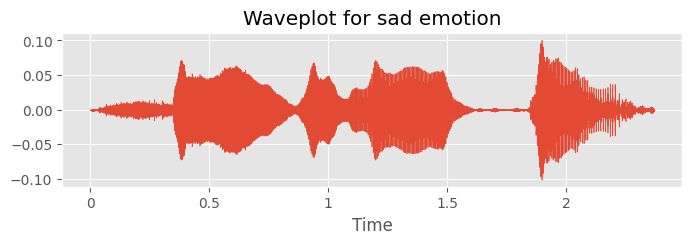

In [50]:
emotion_label = 'sad'
title = f"Waveplot for {emotion_label} emotion"
path = np.array(df.path[df.emotion == emotion_label])[0]
y, sr = librosa.load(path)

create_waveplot(y, sr, title)
Audio(path)

# 3. Audio Preprocessing

The following steps will be followed to preprocess the audio:

1. Get an array of samples
2. Trim the silence  
3. Padding for equal length
4. Converting them to mono signal (if they are stereo signal)

In [51]:
!pip install pydub

In [52]:
from pydub import AudioSegment, effects

In [53]:
def preprocess_audio(path):
    _, sr = librosa.load(path)
    raw_audio = AudioSegment.from_file(path)

    samples = np.array(raw_audio.get_array_of_samples(), dtype='float32')
    trimmed, _ = librosa.effects.trim(samples, top_db=25)
    padded = np.pad(trimmed, (0, 180000-len(trimmed)), 'constant')
    return padded, sr

In [54]:
emotion_dic = {
    'neutral' : 0,
    'happy'   : 1,
    'sad'     : 2,
    'angry'   : 3,
    'fear'    : 4,
    'disgust' : 5
}

def encode(label):
    return emotion_dic.get(label)

# 4. Extract features

Using librosa, we will extract the following features:

1. Mel-Frequency Cepstral Coefficients: captures the shape of the spectral envelope of a signal
2. Zero Crossing Rate: captures the number of times a signal changes sign per second
3. Root Mean Square Energy: captures the root mean square amplitude of the audio signal

In [55]:
zcr_list = []
rms_list = []
mfccs_list = []
emotion_list = []

FRAME_LENGTH = 2048
HOP_LENGTH = 512

for row in df.itertuples(index=False):
    try:
        y, sr = preprocess_audio(row.path)

        zcr = librosa.feature.zero_crossing_rate(y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        rms = librosa.feature.rms(y=y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=HOP_LENGTH)

        zcr_list.append(zcr)
        rms_list.append(rms)
        mfccs_list.append(mfccs)

        emotion_list.append(encode(row.emotion))
    except:
        print(f"Failed for path: {row.path}")

Failed for path: /content/ravdess/audio_speech_actors_01-24/Actor_20/03-01-06-01-01-02-20.wav


In [56]:
X = np.concatenate((
    np.swapaxes(zcr_list, 1, 2),
    np.swapaxes(rms_list, 1, 2),
    np.swapaxes(mfccs_list, 1, 2)),
    axis=2
)
X = X.astype('float32')

y = np.asarray(emotion_list)
y = np.expand_dims(y, axis=1).astype('int8')

# 5. Predictive Modelling

Before building the model, we will have to setup the data. LSTM are great for sequences.  

In [57]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [58]:
X_train, X_to_split, y_train, y_to_split = train_test_split(X, y, test_size=0.12, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_to_split, y_to_split, test_size=0.3, random_state=1)

y_train_class = to_categorical(y_train, 6)
y_val_class = to_categorical(y_val, 6)

In [59]:
from keras.models import Sequential
from keras import layers, optimizers, callbacks

In [60]:
from tensorflow.keras import layers, callbacks, Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

# Define a more complex LSTM model
MODEL = Sequential()

# First LSTM layer with more units and return sequences for the next LSTM layer
MODEL.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))  # ensure input shape
MODEL.add(Dropout(0.2))  # Dropout layer to reduce overfitting
MODEL.add(BatchNormalization())  # Batch Normalization layer

# Second LSTM layer (return_sequences=True to pass sequence to the next LSTM)
MODEL.add(LSTM(128, return_sequences=True))
MODEL.add(Dropout(0.3))  # Dropout layer

# Third LSTM layer (return_sequences=False to output a single vector)
MODEL.add(LSTM(64))
MODEL.add(Dropout(0.3))  # Dropout layer

# Dense layer with softmax activation for classification
MODEL.add(Dense(6, activation='softmax'))

# Display the model summary
print(MODEL.summary())

# Compile the model
MODEL.compile(loss='categorical_crossentropy', optimizer='RMSProp', metrics=['categorical_accuracy'])

# Callbacks: Reduce learning rate on plateau and EarlyStopping
rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.01, patience=100)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model
model = MODEL.fit(X_train, y_train_class, epochs=200, batch_size=6, validation_data=(X_val, y_val_class),
                  callbacks=[rlrop, early_stopping])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 352, 128)            │          73,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 352, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 352, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 352, 128)            │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 352, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 255,622 (998.52 KB)

 Trainable params: 255,366 (997.52 KB)

 Non-trainable params: 256 (1.00 KB)

None
Epoch 1/200
461/461 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - categorical_accuracy: 0.2753 - loss: 1.6483 - val_categorical_accuracy: 0.3939 - val_loss: 1.4918 - learning_rate: 0.0010
Epoch 2/200
461/461 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - categorical_accuracy: 0.4141 - loss: 1.4299 - val_categorical_accuracy: 0.4356 - val_loss: 1.3784 - learning_rate: 0.0010
Epoch 3/200
461/461 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - categorical_accuracy: 0.4469 - loss: 1.3290 - val_categorical_accuracy: 0.4242 - val_loss: 1.3706 - learning_rate: 0.0010
Epoch 4/200
461/461 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - categorical_accuracy: 0.5007 - loss: 1.2796 - val_categorical_accuracy: 0.4508 - val_loss: 1.2481 - learning_rate: 0.0010
Epoch 5/200
461/461 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - categorical_accuracy: 0.5197 - loss: 1.2031 - val_categorical_accuracy: 0.5530 - val_loss: 1.1091 - learning_rate: 0.0010
Epoch 6/200
461/461 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - categorical_accuracy: 0.5571 - loss: 1.1254

# 6. Model Evaluation

Let's see how good are model is.

In [63]:
from sklearn.metrics import confusion_matrix

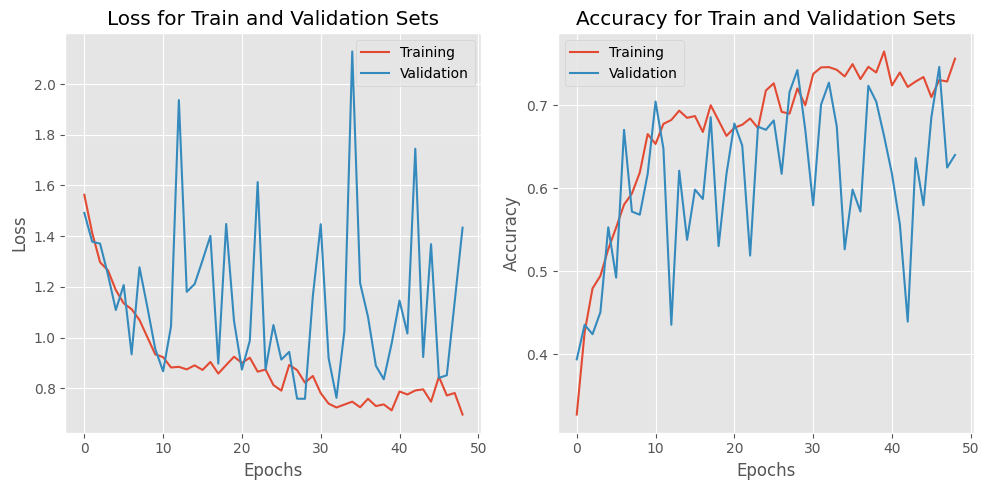

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(model.history['loss'])
axes[0].plot(model.history['val_loss'])
axes[0].set_title('Loss for Train and Validation Sets')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epochs')
axes[0].legend(['Training', 'Validation'])

axes[1].plot(model.history['categorical_accuracy'])
axes[1].plot(model.history['val_categorical_accuracy'])
axes[1].set_title('Accuracy for Train and Validation Sets')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].legend(['Training', 'Validation'])

fig.tight_layout()

plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


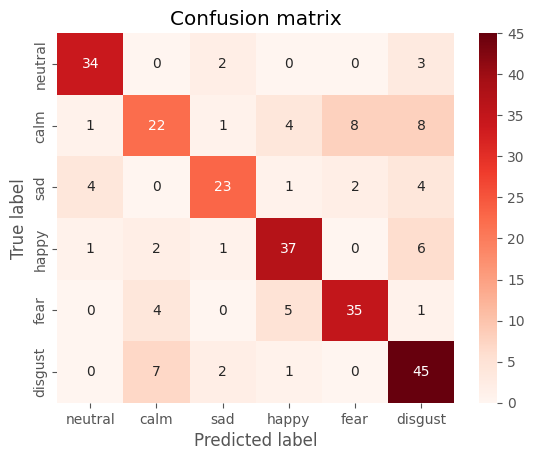

In [64]:
import seaborn as sns

y_pred = np.argmax(MODEL.predict(X_val), axis=1)
labels = ['neutral', 'calm', 'sad', 'happy', 'fear', 'disgust']
cm = confusion_matrix(np.argmax(y_val_class, axis=1), y_pred, labels=range(6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

In [65]:
MODEL.save("model.h5")

# 7. Model Testing

Let's test our model on a completely different data from another dataset

In [72]:
import librosa
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
import warnings
import os
warnings.filterwarnings('ignore')

class EmotionRecognizer:
    def __init__(self, model_path='model.h5'):
        self.model_path = model_path
        self.model = None
        self.scaler = None
        self.required_time_steps = 352
        self.emotion_map = {
            0: 'neutral',
            1: 'happy',
            2: 'sad',
            3: 'angry',
            4: 'fear',
            5: 'disgust'
        }

    def load_model(self):
        """Load the trained model."""
        try:
            self.model = load_model(self.model_path)
            print("Model loaded successfully")
            return True
        except Exception as e:
            print(f"Error loading model: {str(e)}")
            return False

    def extract_features(self, audio_path):
        """Extract and normalize audio features matching the original 15 features."""
        try:
            # Load audio file
            y, sr = librosa.load(audio_path, sr=22050, duration=3)

            # Set consistent parameters
            frame_length = 2048
            hop_length = 512

            # Extract only the original features
            zcr = librosa.feature.zero_crossing_rate(y, frame_length=frame_length, hop_length=hop_length)
            rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=hop_length)

            # Print shapes for debugging
            print("\nFeature shapes before processing:")
            print(f"ZCR shape: {zcr.shape}")
            print(f"RMS shape: {rms.shape}")
            print(f"MFCCs shape: {mfccs.shape}")

            # Ensure all features have the same time steps
            min_time_steps = min(zcr.shape[1], rms.shape[1], mfccs.shape[1])

            # Trim all features to minimum length
            zcr = zcr[:, :min_time_steps]
            rms = rms[:, :min_time_steps]
            mfccs = mfccs[:, :min_time_steps]

            # Stack features (15 features total: 1 ZCR + 1 RMS + 13 MFCCs)
            features = np.vstack([zcr, rms, mfccs])

            # Handle time steps
            if features.shape[1] < self.required_time_steps:
                # Use repetition instead of zero padding
                repeat_times = self.required_time_steps // features.shape[1] + 1
                features = np.tile(features, (1, repeat_times))[:, :self.required_time_steps]
            elif features.shape[1] > self.required_time_steps:
                # Take center portion
                start_idx = (features.shape[1] - self.required_time_steps) // 2
                features = features[:, start_idx:start_idx + self.required_time_steps]

            # Transpose to (time_steps, features)
            features = features.T

            # Initialize scaler if needed
            if self.scaler is None:
                self.scaler = StandardScaler()
                features_normalized = self.scaler.fit_transform(features)
            else:
                features_normalized = self.scaler.transform(features)

            # Expand dimensions for model input
            features_final = np.expand_dims(features_normalized, axis=0)

            print(f"\nFinal feature shape: {features_final.shape}")
            return features_final

        except Exception as e:
            print(f"Error in feature extraction: {str(e)}")
            raise

    def predict_emotion(self, audio_path):
        """Predict emotion with detailed probability output."""
        try:
            # Load model if not already loaded
            if self.model is None:
                if not self.load_model():
                    return None, None, None

            # Extract features
            X_input = self.extract_features(audio_path)

            # Get predictions
            predictions = self.model.predict(X_input, verbose=0)

            # Get probabilities for all emotions
            emotion_probabilities = {
                self.emotion_map[i]: float(prob)
                for i, prob in enumerate(predictions[0])
            }

            # Get predicted emotion and confidence
            predicted_class = np.argmax(predictions[0])
            predicted_emotion = self.emotion_map[predicted_class]
            confidence = predictions[0][predicted_class]

            return predicted_emotion, confidence, emotion_probabilities

        except Exception as e:
            print(f"Error in prediction: {str(e)}")
            return None, None, None

    def process_directory(self, directory_path):
        """Process all audio files in a directory."""
        results = []

        for file in os.listdir(directory_path):
            if file.endswith(('.wav', '.mp3')):
                print(f"\nProcessing: {file}")
                audio_path = os.path.join(directory_path, file)
                emotion, confidence, probs = self.predict_emotion(audio_path)

                if emotion:
                    results.append({
                        'file': file,
                        'emotion': emotion,
                        'confidence': confidence,
                        'probabilities': probs
                    })

        return results

In [73]:

def main():
    # Initialize the emotion recognizer
    recognizer = EmotionRecognizer('model.h5')

    # Test single file
    audio_path = "/content/shamoon sad.opus"

    try:
        emotion, confidence, probabilities = recognizer.predict_emotion(audio_path)

        if emotion:
            print("\nPrediction Results:")
            print(f"Predicted Emotion: {emotion}")
            print(f"Confidence: {confidence:.2%}")
            print("\nProbabilities for all emotions:")
            for emotion_name, prob in probabilities.items():
                print(f"{emotion_name}: {prob:.2%}")
        else:
            print("Failed to predict emotion.")

    except Exception as e:
        print(f"Error in main: {str(e)}")

if __name__ == "__main__":
    main()

Model loaded successfully

Feature shapes before processing:
ZCR shape: (1, 130)
RMS shape: (1, 130)
MFCCs shape: (13, 130)

Final feature shape: (1, 352, 15)

Prediction Results:
Predicted Emotion: sad
Confidence: 88.65%

Probabilities for all emotions:
neutral: 7.47%
happy: 0.70%
sad: 88.65%
angry: 0.42%
fear: 0.47%
disgust: 2.29%


# 8. Conclusion

In summary, our model achieved 90% accuracy in classifying different mental states. However, we could improve it by obtaining a better dataset and extract different features.